Ссылка на kaggle: https://www.kaggle.com/c/advanced-dls-spring-2021/

In [ ]:
!gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K  # train.csv
!gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r  # test.csv
!gdown 199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y  # submission.csv
!pip install catboost

Downloading...
From: https://drive.google.com/uc?id=1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K
To: /content/train.csv
100% 664k/664k [00:00<00:00, 5.51MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r
To: /content/test.csv
100% 218k/218k [00:00<00:00, 3.40MB/s]
Downloading...
From: https://drive.google.com/uc?id=199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y
To: /content/submission.csv
100% 14.7k/14.7k [00:00<00:00, 43.0MB/s]


### Загрузка Данных

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer

In [ ]:
data = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [ ]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

In [ ]:
data['TotalSpent'].value_counts()

           9
20.2       9
19.75      8
20.05      6
19.65      6
          ..
41.85      1
4326.25    1
950.2      1
4264       1
1375.6     1
Name: TotalSpent, Length: 4978, dtype: int64

In [ ]:
data = data.replace(' ', np.nan)
test = test.replace(' ', np.nan)
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  9
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [ ]:
data.TotalSpent.fillna(data.TotalSpent.median(), inplace=True)
test.TotalSpent.fillna(test.TotalSpent.median(), inplace=True)
data['TotalSpent'] = data['TotalSpent'].astype(float)
test['TotalSpent'] = test['TotalSpent'].astype(float)

### Анализ Данных

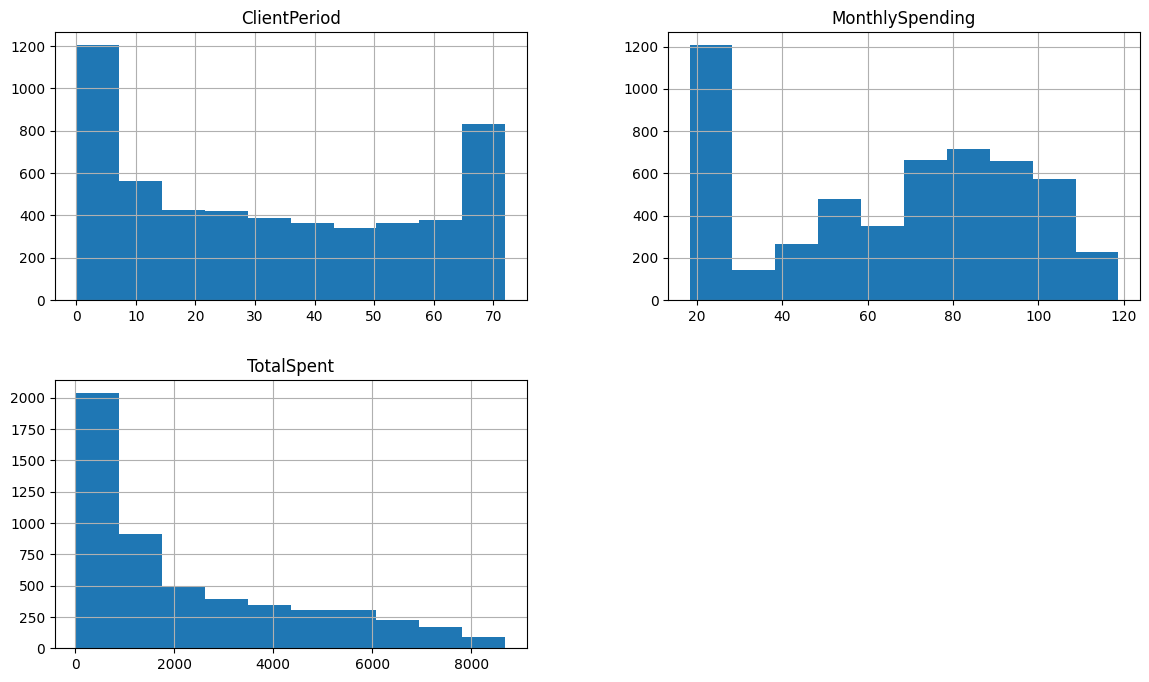

In [ ]:
data.hist(column=num_cols, figsize=(14, 8))
print()

In [ ]:
# Посмотрим на распределение категориальных фичей
for col in cat_cols:
    print(f"{col} DISTRIBUTION")
    print(data[col].value_counts())
    print()

Sex DISTRIBUTION
Male      2655
Female    2627
Name: Sex, dtype: int64

IsSeniorCitizen DISTRIBUTION
0    4440
1     842
Name: IsSeniorCitizen, dtype: int64

HasPartner DISTRIBUTION
No     2705
Yes    2577
Name: HasPartner, dtype: int64

HasChild DISTRIBUTION
No     3676
Yes    1606
Name: HasChild, dtype: int64

HasPhoneService DISTRIBUTION
Yes    4761
No      521
Name: HasPhoneService, dtype: int64

HasMultiplePhoneNumbers DISTRIBUTION
No                  2511
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64

HasInternetService DISTRIBUTION
Fiber optic    2341
DSL            1800
No             1141
Name: HasInternetService, dtype: int64

HasOnlineSecurityService DISTRIBUTION
No                     2612
Yes                    1529
No internet service    1141
Name: HasOnlineSecurityService, dtype: int64

HasOnlineBackup DISTRIBUTION
No                     2332
Yes                    1809
No internet service    1141
Name: HasOnlineBackup, dty

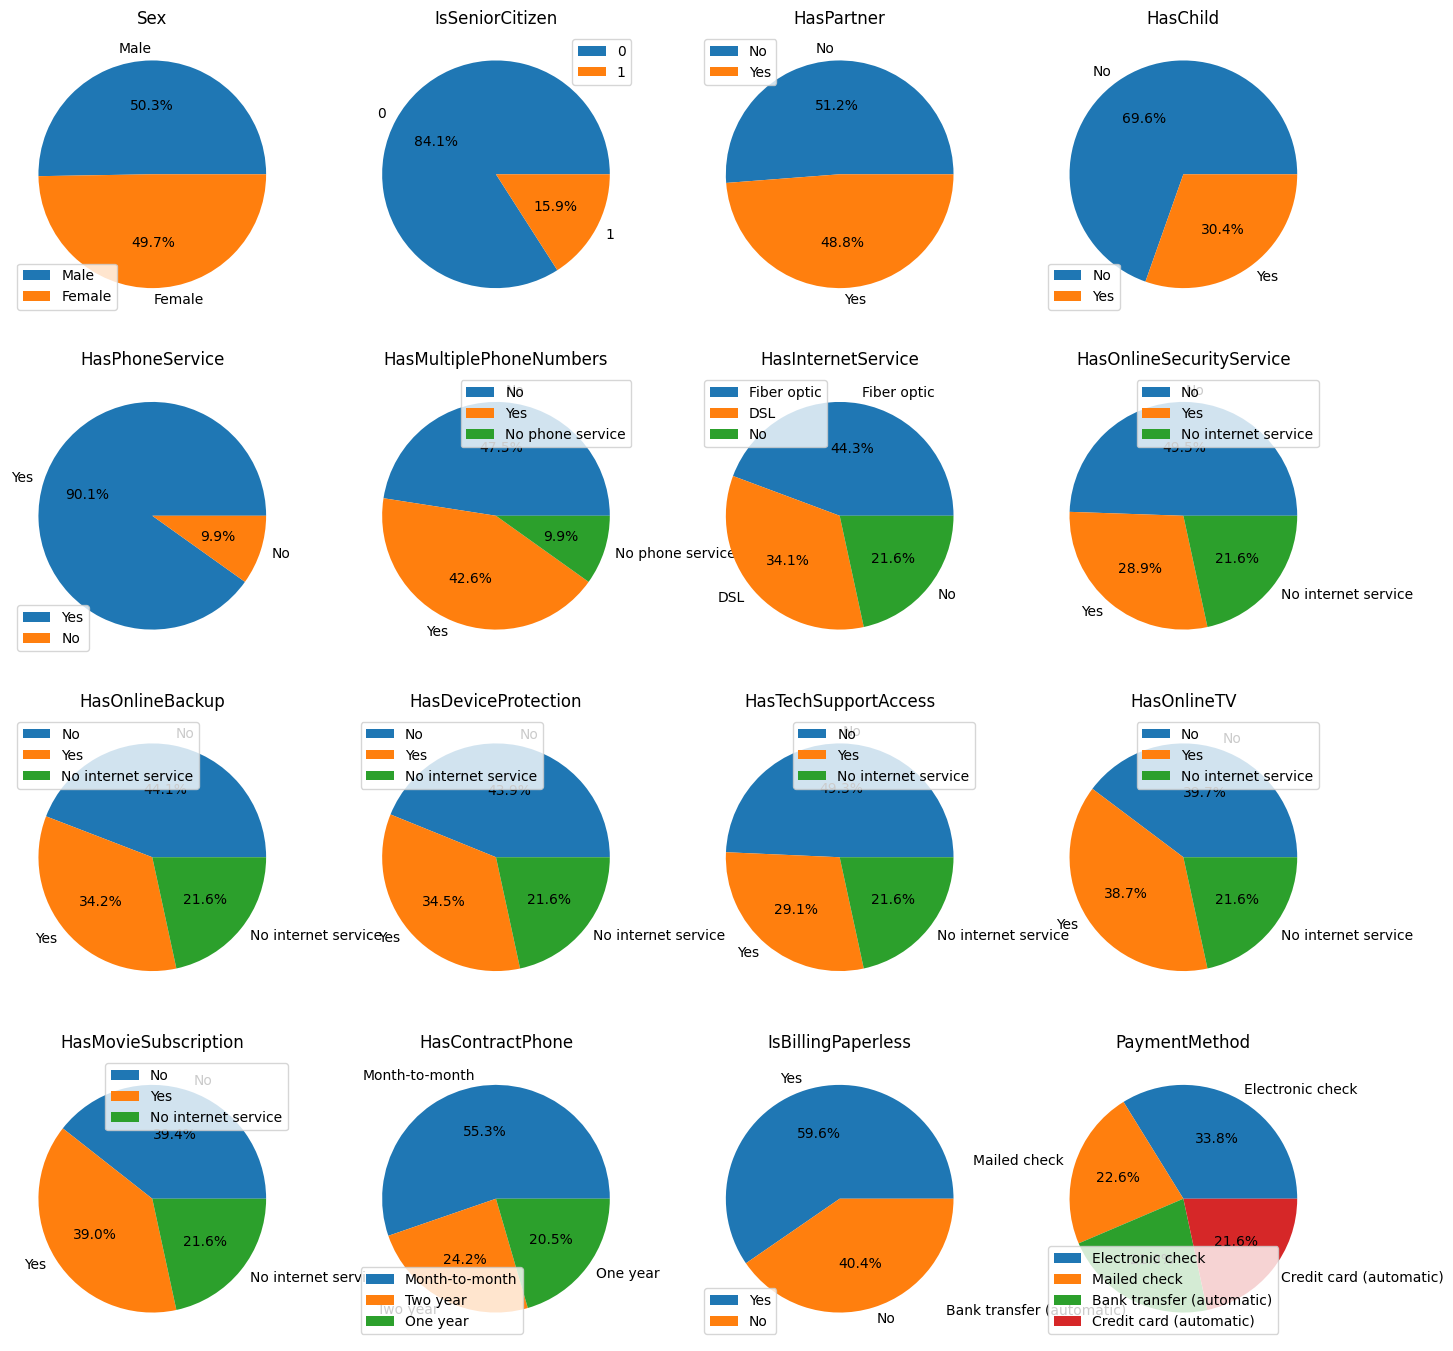

In [ ]:
fig = plt.figure(figsize=(17, 17))

for i in range(len(cat_cols)):
    data_i = data[cat_cols[i]].value_counts()
    plt.subplot(4, 4, i+1)
    plt.pie(data_i, labels = data_i.index, autopct='%1.1f%%')
    plt.title(cat_cols[i])
    plt.legend()

In [ ]:
print(f"{target_col} DISTRIBUTION")
print(data[target_col].value_counts())

Churn DISTRIBUTION
0    3898
1    1384
Name: Churn, dtype: int64


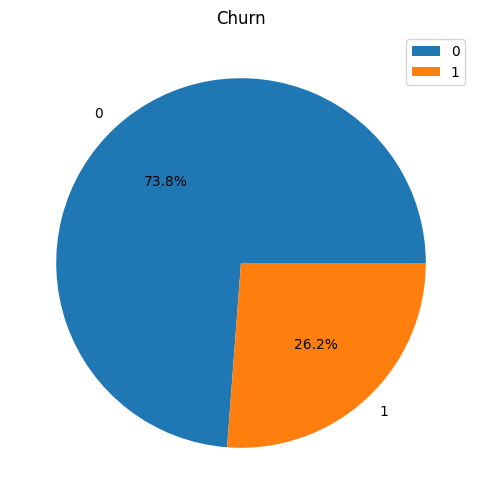

In [ ]:
fig = plt.figure(figsize=(6, 6))
plt.pie(data[target_col].value_counts(), labels=data[target_col].value_counts().index, autopct='%1.1f%%')
plt.title(target_col)
plt.legend()
print()

<Axes: >

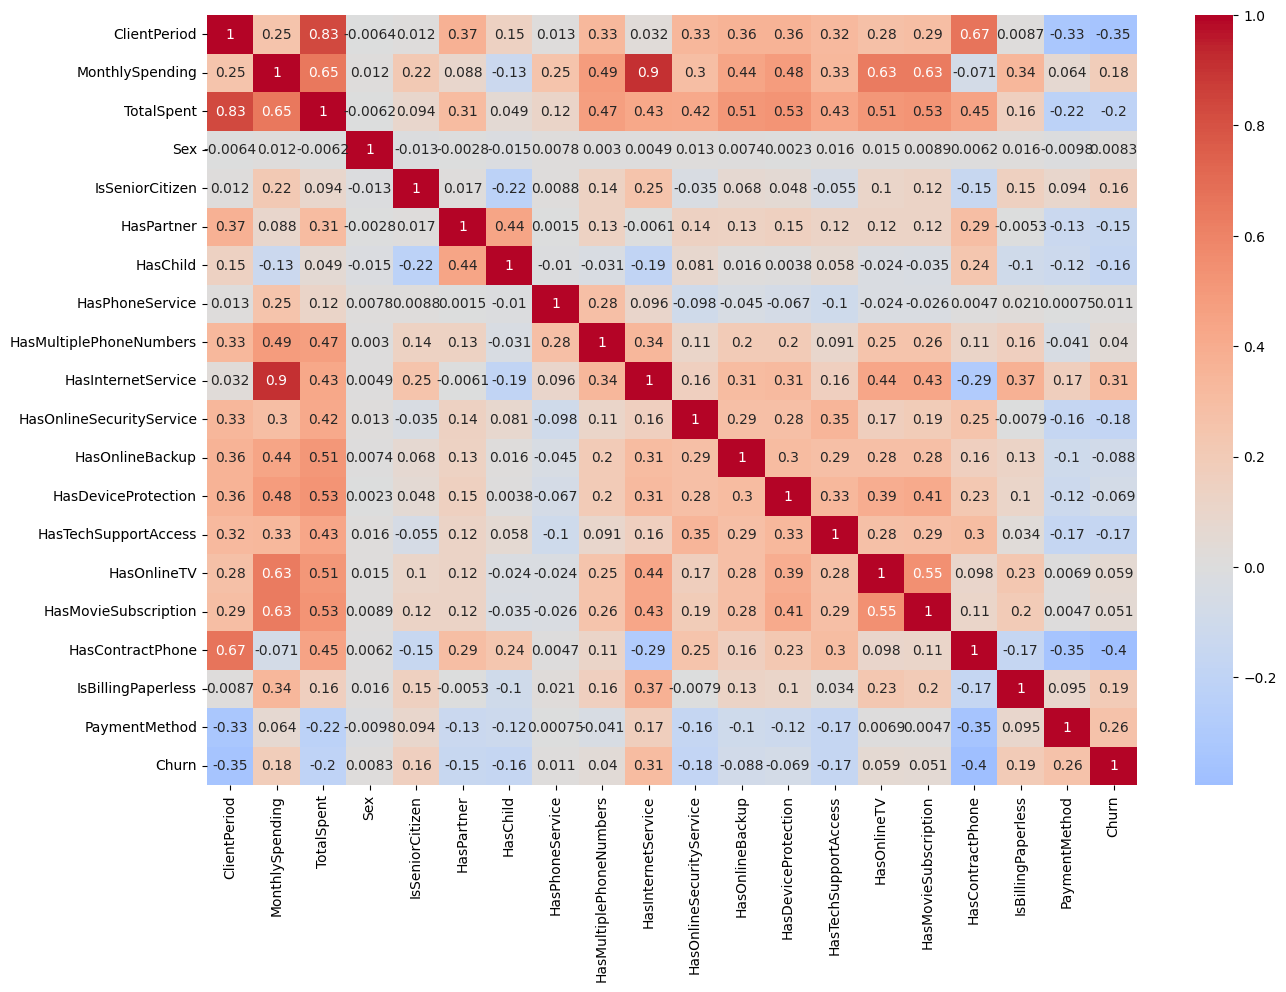

In [ ]:
patterns = {
    "No": 0,
    "No internet service": 0,
    "No phone service": 0,
    "Yes": 1,
    "Male": 0,
    "Female": 1,
    "DSL": 1,
    "Fiber optic": 2,
    "Month-to-month": 0,
    "One year": 1,
    "Two year": 2,
    "Credit card (automatic)": 0,
    "Bank transfer (automatic)": 1,
    "Mailed check": 2,
    "Electronic check": 3,
}

data_corr = data.replace(patterns)
sns.heatmap(data_corr.corr(), annot=True, cmap="coolwarm", center=0, ax=plt.subplots(figsize=(15, 10))[1])

### Применение Линейных Моделей

In [ ]:
X = data[num_cols + cat_cols]
y = data[target_col].values

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)

In [ ]:
prep_data = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(), cat_cols)
    ])

### Logistic Regression

In [ ]:
clf = Pipeline(steps=[
        ('prep', prep_data),
        ("LR", LogisticRegression(random_state=42))
    ])

params = [
        {
        'LR__penalty':['l1'],
        'LR__C': [4.1753],
        'LR__solver': ['saga']
    }
]

search_LR = GridSearchCV(
    estimator=clf,
    param_grid=params,
    scoring='roc_auc',
    cv=5,
    verbose=10,
    n_jobs=-1,
    refit=True
)

In [ ]:
search_LR.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ClientPeriod',
                                                                          'MonthlySpending',
                                                                          'TotalSpent']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Sex',
                                                                          'IsSeniorCitizen',
                                                                          'HasPartner',
                                                                          'HasChild',
                                                                          'HasPhoneService',
                                                                          'HasMultiplePhoneNumbers',
                                                                          'HasInternetService',
                                                                          'HasOnlineSecurityService',
                                                                          'HasOnlineBackup',
                                                                          'HasDeviceProtection',
                                                                          'HasTechSupportAccess',
                                                                          'HasOnlineTV',
                                                                          'HasMovieSubscription',
                                                                          'HasContractPhone',
                                                                          'IsBillingPaperless',
                                                                          'PaymentMethod'])])),
                                       ('LR',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'LR__C': [4.1753], 'LR__penalty': ['l1'],
                          'LR__solver': ['saga']}],
             scoring='roc_auc', verbose=10)

In [ ]:
print(search_LR.best_params_)

{'LR__C': 4.1753, 'LR__penalty': 'l1', 'LR__solver': 'saga'}


In [ ]:
print(f"Train Score: {roc_auc_score(y_train, search_LR.predict_proba(X_train)[:, 1])}")
print(f"Val Score: {roc_auc_score(y_val, search_LR.predict_proba(X_val)[:, 1])}")

Train Score: 0.8534657790697743
Val Score: 0.8284140338563554


### Градиентный Бустинг (CatBoost)

In [ ]:
clf = Pipeline(steps=[
        ('prep', prep_data),
        ("CB", CatBoostClassifier(random_state=42))
    ])

params = [
        {
        "CB__n_estimators": [250],
        "CB__learning_rate": [0.05],  # [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.04, 0.05, 0.1, 0.2, 0.3, 0.5],
        "CB__max_depth": [4],  # np.arange(4, 20, 1),
        "CB__l2_leaf_reg": [10],  # np.arange(0.1, 1, 0.05),
        "CB__subsample": [0.5],  # [3, 5, 7, 10],
        "CB__random_strength": [5],  # [1, 2, 5, 10, 20, 50, 100],
        "CB__min_data_in_leaf": [100],  # np.arange(10, 1001, 10),
    }
]

search_CB = GridSearchCV(
    estimator=clf,
    param_grid=params,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

In [ ]:
search_CB.fit(X_train, y_train)

0:	learn: 0.6648149	total: 4.14ms	remaining: 1.03s
1:	learn: 0.6360647	total: 9.69ms	remaining: 1.2s
2:	learn: 0.6125023	total: 14.8ms	remaining: 1.22s
3:	learn: 0.5883556	total: 25.6ms	remaining: 1.57s
4:	learn: 0.5726010	total: 30.2ms	remaining: 1.48s
5:	learn: 0.5562540	total: 34.9ms	remaining: 1.42s
6:	learn: 0.5452575	total: 39.1ms	remaining: 1.36s
7:	learn: 0.5320362	total: 43.8ms	remaining: 1.32s
8:	learn: 0.5241692	total: 48.1ms	remaining: 1.29s
9:	learn: 0.5154715	total: 50.1ms	remaining: 1.2s
10:	learn: 0.5080854	total: 52.7ms	remaining: 1.14s
11:	learn: 0.4999022	total: 54.7ms	remaining: 1.08s
12:	learn: 0.4921866	total: 56.6ms	remaining: 1.03s
13:	learn: 0.4859387	total: 58.4ms	remaining: 985ms
14:	learn: 0.4810847	total: 60.7ms	remaining: 951ms
15:	learn: 0.4741307	total: 63.2ms	remaining: 924ms
16:	learn: 0.4690978	total: 65.1ms	remaining: 892ms
17:	learn: 0.4637587	total: 67ms	remaining: 863ms
18:	learn: 0.4622204	total: 68.3ms	remaining: 830ms
19:	learn: 0.4587395	total

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ClientPeriod',
                                                                          'MonthlySpending',
                                                                          'TotalSpent']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Sex',
                                                                          'IsSeniorCitizen',
                                                                          'HasPartner',
                                                                          'HasChild',
                                                                          'HasPhoneService',
                                                                          'HasMultiplePhoneNumbers',
                                                                          'HasInternetService',
                                                                          'HasOnlineSecurityService',
                                                                          'HasOnlineBackup',
                                                                          'HasDeviceP...
                                                                          'HasMovieSubscription',
                                                                          'HasContractPhone',
                                                                          'IsBillingPaperless',
                                                                          'PaymentMethod'])])),
                                       ('CB',
                                        <catboost.core.CatBoostClassifier object at 0x7c625f364190>)]),
             n_jobs=-1,
             param_grid=[{'CB__l2_leaf_reg': [10], 'CB__learning_rate': [0.05],
                          'CB__max_depth': [4], 'CB__min_data_in_leaf': [100],
                          'CB__n_estimators': [250], 'CB__random_strength': [5],
                          'CB__subsample': [0.5]}],
             scoring='roc_auc')

In [ ]:
print(search_CB.best_params_)

{'CB__l2_leaf_reg': 10, 'CB__learning_rate': 0.05, 'CB__max_depth': 4, 'CB__min_data_in_leaf': 100, 'CB__n_estimators': 250, 'CB__random_strength': 5, 'CB__subsample': 0.5}


In [ ]:
print(f"Train Score: {roc_auc_score(y_train, search_CB.predict_proba(X_train)[:, 1])}")
print(f"Val Score: {roc_auc_score(y_val, search_CB.predict_proba(X_val)[:, 1])}")

Train Score: 0.8755873845595478
Val Score: 0.831260793675714


### KNN

In [ ]:
clf = Pipeline(steps=[
        ('prep', prep_data),
        ("KNN", KNeighborsClassifier())
    ])

params = [
        {
        "KNN__n_neighbors": [75],
        "KNN__metric": ["euclidean"]
    }
]

search_KNN = GridSearchCV(
    estimator=clf,
    param_grid=params,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    refit=True
)

In [ ]:
search_KNN.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ClientPeriod',
                                                                          'MonthlySpending',
                                                                          'TotalSpent']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Sex',
                                                                          'IsSeniorCitizen',
                                                                          'HasPartner',
                                                                          'HasChild',
                                                                          'HasPhoneService',
                                                                          'HasMultiplePhoneNumbers',
                                                                          'HasInternetService',
                                                                          'HasOnlineSecurityService',
                                                                          'HasOnlineBackup',
                                                                          'HasDeviceProtection',
                                                                          'HasTechSupportAccess',
                                                                          'HasOnlineTV',
                                                                          'HasMovieSubscription',
                                                                          'HasContractPhone',
                                                                          'IsBillingPaperless',
                                                                          'PaymentMethod'])])),
                                       ('KNN', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid=[{'KNN__metric': ['euclidean'],
                          'KNN__n_neighbors': [75]}],
             scoring='roc_auc')

In [ ]:
print(search_KNN.best_params_)

{'KNN__metric': 'euclidean', 'KNN__n_neighbors': 75}


In [ ]:
print(f"Train Score: {roc_auc_score(y_train, search_KNN.predict_proba(X_train)[:, 1])}")
print(f"Val Score: {roc_auc_score(y_val, search_KNN.predict_proba(X_val)[:, 1])}")

Train Score: 0.8500013334825288
Val Score: 0.813367534470498


### Random Forest

In [ ]:
clf = Pipeline(steps=[
        ('prep', prep_data),
        ("RF", RandomForestClassifier(random_state=42))
    ])

params = [
        {
        "RF__n_estimators": [250],
        "RF__min_samples_split": [10],
        "RF__min_samples_leaf": [30],
        "RF__max_depth": [5]
    }
]

search_RF = GridSearchCV(
    estimator=clf,
    param_grid=params,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    refit=True
)

In [ ]:
search_RF.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ClientPeriod',
                                                                          'MonthlySpending',
                                                                          'TotalSpent']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Sex',
                                                                          'IsSeniorCitizen',
                                                                          'HasPartner',
                                                                          'HasChild',
                                                                          'HasPhoneService',
                                                                          'HasMultiplePhoneNumbers',
                                                                          'HasInternetService',
                                                                          'HasOnlineSecurityService',
                                                                          'HasOnlineBackup',
                                                                          'HasDeviceProtection',
                                                                          'HasTechSupportAccess',
                                                                          'HasOnlineTV',
                                                                          'HasMovieSubscription',
                                                                          'HasContractPhone',
                                                                          'IsBillingPaperless',
                                                                          'PaymentMethod'])])),
                                       ('RF',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'RF__max_depth': [5], 'RF__min_samples_leaf': [30],
                          'RF__min_samples_split': [10],
                          'RF__n_estimators': [250]}],
             scoring='roc_auc')

In [ ]:
print(search_RF.best_params_)

{'RF__max_depth': 5, 'RF__min_samples_leaf': 30, 'RF__min_samples_split': 10, 'RF__n_estimators': 250}


In [ ]:
print(f"Train Score: {roc_auc_score(y_train, search_RF.predict_proba(X_train)[:, 1])}")
print(f"Val Score: {roc_auc_score(y_val, search_RF.predict_proba(X_val)[:, 1])}")

Train Score: 0.861175337298608
Val Score: 0.8231568788614808


### Stacking

In [ ]:
meta = CatBoostClassifier(
    logging_level='Silent',
    eval_metric="AUC:hints=skip_train~false",
    metric_period=1000,
    random_seed=0,
    grow_policy="Depthwise",
    l2_leaf_reg=1,
    learning_rate=0.08,
    max_depth=10,
    min_data_in_leaf=10,
    n_estimators=10,
    random_strength=11,
    subsample=0.1,
)

stacking = StackingClassifier(
    estimators=[
        ("LR", search_LR),
        ("KNN", search_KNN),
        ("RF", search_RF),
        ("CB", search_CB),
    ],
    final_estimator=meta,
    n_jobs=-1,
)

stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('LR',
                                GridSearchCV(cv=5,
                                             estimator=Pipeline(steps=[('prep',
                                                                        ColumnTransformer(transformers=[('num',
                                                                                                         StandardScaler(),
                                                                                                         ['ClientPeriod',
                                                                                                          'MonthlySpending',
                                                                                                          'TotalSpent']),
                                                                                                        ('cat',
                                                                                                         OneHotEncoder(),
                                                                                                         ['Sex',
                                                                                                          'IsSeniorCitizen',
                                                                                                          'HasPartner',
                                                                                                          'HasChild',
                                                                                                          'HasPhoneService',
                                                                                                          'HasMultiplePhoneNumbers',
                                                                                                          'HasInternetService',
                                                                                                          'HasOnlineSecurityS...
                                                                        <catboost.core.CatBoostClassifier object at 0x7c625f364190>)]),
                                             n_jobs=-1,
                                             param_grid=[{'CB__l2_leaf_reg': [10],
                                                          'CB__learning_rate': [0.05],
                                                          'CB__max_depth': [4],
                                                          'CB__min_data_in_leaf': [100],
                                                          'CB__n_estimators': [250],
                                                          'CB__random_strength': [5],
                                                          'CB__subsample': [0.5]}],
                                             scoring='roc_auc'))],
                   final_estimator=<catboost.core.CatBoostClassifier object at 0x7c625f45a740>,
                   n_jobs=-1)

In [ ]:
print(f"Train Score: {roc_auc_score(y_train, stacking.predict_proba(X_train)[:, 1])}")
print(f"Val Score: {roc_auc_score(y_val, stacking.predict_proba(X_val)[:, 1])}")

Train Score: 0.8663225798596597
Val Score: 0.8287280316953113


### Предсказания

In [ ]:
best_model = stacking

In [ ]:
submission = pd.read_csv('./submission.csv')
submission['Churn'] = best_model.predict_proba(test)[:, 1]
submission.to_csv('./my_submission.csv')